In [3]:
# ✅ Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
from tqdm import tqdm

In [5]:

# -------------------------------
# Step 1: Setup GPU (CUDA) Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔍 Using device: {device}")
if device.type == 'cuda':
    print(f"🧠 CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"🔋 Memory Allocated: {round(torch.cuda.memory_allocated(0)/1024**3, 2)} GB")


🔍 Using device: cuda
🧠 CUDA Device Name: NVIDIA GeForce RTX 3060
🔋 Memory Allocated: 0.0 GB


In [18]:

# -------------------------------
# Step 2: Paths to image folders
# -------------------------------
train_dir = "C:\\yolo realcolon work\\feature_extraction\\dataset_for_feature_extraction\\train_polyp"
val_dir   = "C:\\yolo realcolon work\\feature_extraction\\dataset_for_feature_extraction\\val_polyp"



In [20]:


# -------------------------------
# Step 3: Define preprocessing
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


In [12]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root=r"C:\yolo realcolon work\feature_extraction\dataset_for_feature_extraction\train_polyp")
print("Classes:", dataset.classes)


Classes: ['polyp']


In [21]:

# -------------------------------
# Step 4: Load datasets
# -------------------------------
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [22]:



# -------------------------------
# Step 5: Load MobileNetV2 model
# -------------------------------
model = mobilenet_v2(pretrained=True)
model.classifier = torch.nn.Identity()  # Remove classification head
model.to(device)
model.eval()


c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 47.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [23]:

# -------------------------------
# Step 6: Feature extraction function
# -------------------------------
def extract_features(dataloader, dataset, dataset_type="train"):
    all_features = []
    all_filenames = []

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc=f"Extracting {dataset_type} features"):
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())

        # Get the corresponding file paths (in same order as dataloader)
        for path, _ in dataset.samples:
            all_filenames.append(os.path.basename(path))  # just filename

    all_features = np.vstack(all_features)
    return all_features, all_filenames


In [24]:

# -------------------------------
# Step 7: Extract features
# -------------------------------
train_features, train_filenames = extract_features(train_loader, train_dataset, "train")
val_features, val_filenames = extract_features(val_loader, val_dataset, "val")


Extracting val features: 100%|██████████| 112/112 [00:24<00:00,  4.64it/s]


In [25]:

# -------------------------------
# Step 8: Save features to disk
# -------------------------------
np.save("mobilenet_train_features.npy", train_features)
np.save("mobilenet_val_features.npy", val_features)

# Optionally, save to CSV with filenames
pd.DataFrame(train_features, index=train_filenames).to_csv("mobilenet_train_features.csv")
pd.DataFrame(val_features, index=val_filenames).to_csv("mobilenet_val_features.csv")

print("✅ Feature extraction complete. Files saved.")


✅ Feature extraction complete. Files saved.


# clustering


In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature CSV (including filename column)
df = pd.read_csv("mobilenet_train_features.csv")

# ✅ Remove non-numeric columns (like filenames)
numeric_df = df.select_dtypes(include=[np.number])
features = numeric_df.values  # clean, only numeric

In [35]:
# ✅ Apply PCA
pca = PCA(n_components=50, random_state=42)
features_reduced = pca.fit_transform(features)

In [38]:
# Step 3: KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(features_reduced)

In [42]:
# Step 4: DBSCAN clustering
scaled = StandardScaler().fit_transform(features_reduced)
dbscan = DBSCAN(eps=5.0, min_samples=5)

dbscan_labels = dbscan.fit_predict(scaled)

In [43]:
# Step 5: Save or inspect clustering results
df_results = pd.DataFrame(features_reduced, columns=[f"PC{i}" for i in range(1, 51)])
df_results["kmeans_label"] = kmeans_labels
df_results["dbscan_label"] = dbscan_labels
df_results.to_csv("clustered_features.csv", index=False)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6084\504845120.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


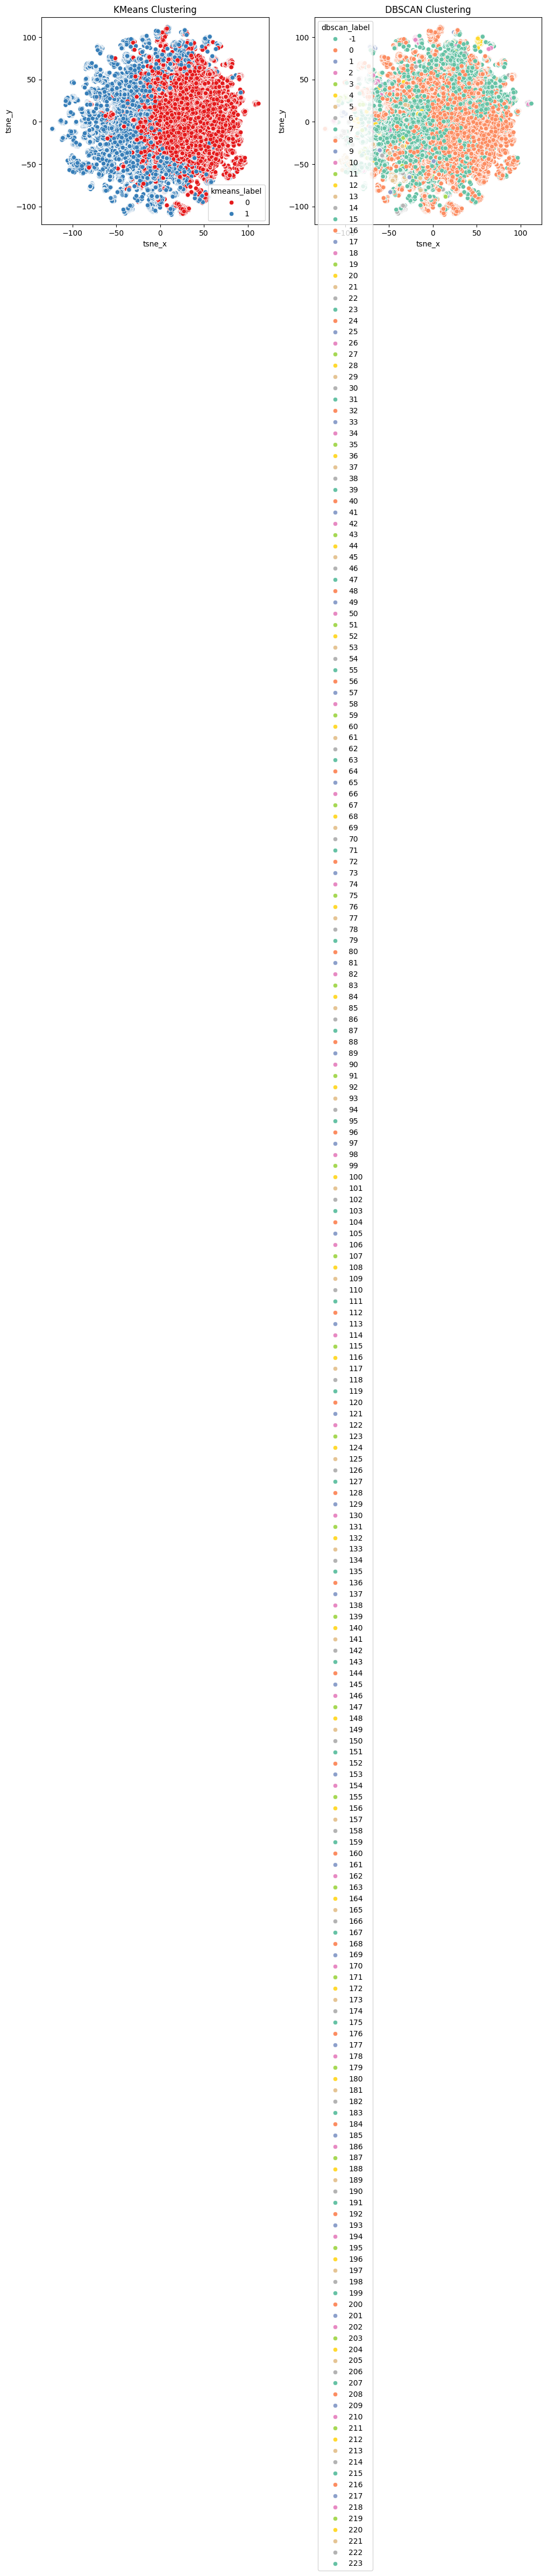

In [44]:
# Step 6: Visualize clusters with t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_2d = tsne.fit_transform(features_reduced)
df_results["tsne_x"] = tsne_2d[:, 0]
df_results["tsne_y"] = tsne_2d[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_results, x="tsne_x", y="tsne_y", hue="kmeans_label", palette="Set1")
plt.title("KMeans Clustering")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_results, x="tsne_x", y="tsne_y", hue="dbscan_label", palette="Set2")
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()